In [82]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
from math import log, e
import math
from sklearn.utils import shuffle
import os
import pickle

In [57]:
df = pd.read_csv('../Data/data_1/connect-4.data',header=None)

In [58]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
1,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
2,b,b,b,b,b,b,o,b,b,b,...,b,b,b,b,b,b,b,b,b,win
3,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
4,o,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
5,b,b,b,b,b,b,b,b,b,b,...,b,b,b,o,b,b,b,b,b,win
6,b,b,b,b,b,b,x,b,b,b,...,b,b,b,b,b,b,b,b,b,draw
7,b,b,b,b,b,b,x,b,b,b,...,b,b,b,b,b,b,b,b,b,win
8,b,b,b,b,b,b,x,o,b,b,...,b,b,b,b,b,b,b,b,b,win
9,b,b,b,b,b,b,x,b,b,b,...,b,b,b,b,b,b,b,b,b,win


In [59]:
df = df.rename(columns = {42:'tag'})

In [60]:
for i in set(df['tag']) :
    _list = list(df['tag'])
    c = _list.count(i)
    print('Class :', i,'| count :',c )

Class : draw | count : 6449
Class : win | count : 44473
Class : loss | count : 16635


In [61]:
# there are 3 classes 
# taking the majority class as normal 
# Take samples from minority class 'draw' the class(es) with minimum number of points as anomalous
# this assumption has been done in CompreX

normal_class = 'win'
anomaly_class_1 = 'draw'
anomaly_class_2 = 'loss'
num_samples_anomaly = int(min(len(df[df['tag']==anomaly_class_1]) + len(df[df['tag']==anomaly_class_2]) , 0.05*len(df[df['tag']==normal_class])))

## Add in id


In [62]:
# add in id
new_col = list(range(1,len(df)+1))
df.insert(
    loc=0, 
    column='id', 
    value=new_col
)

In [63]:
normal = df[df['tag']==normal_class]
anomaly = df[(df['tag']==anomaly_class_1) | (df['tag']==anomaly_class_2)].sample(num_samples_anomaly)


In [64]:
len(normal)

44473

In [65]:
len(anomaly)

2223

In [66]:
data_df = pd.DataFrame(normal,copy=True)
data_df = data_df.append(anomaly,ignore_index=True)

In [67]:

data_df = shuffle(data_df)

In [68]:
len(data_df)

46696

In [69]:
l1 = len(data_df[data_df['tag']==normal_class])
l2 = len(data_df)
l1 = l2-l1
print('Percentage of Anomalies :',  (l1/l2)*100 )

Percentage of Anomalies : 4.760579064587973


### Exploring the attributes


In [70]:
def entropy_calc(labels):
    n_labels = len(labels)
    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.
    base = math.e 
    for i in probs:
        ent -= i * log(i, base)
    k = len(value)
    ent = ent/log(k,base)
    return ent

In [71]:
def get_entropies(df):
    # ignore 1st and last columns
    num_cols = len(df.columns)
    res = {}
    for i in range(1,num_cols-2):
        e = entropy_calc(list(df[i]))
        print(i,e)
        res[i] = e
    return res

In [72]:
attr_entropy = get_entropies(data_df)


1 0.8128945753630282
2 0.5365619606382177
3 0.3146268433035423
4 0.1493179119568422
5 0.044940655988095775
6 0.9990646046935685
7 0.860560133209749
8 0.5712390656502361
9 0.348553619124691
10 0.16228135746027628
11 0.04636793635741619
12 0.9639275288931365
13 0.9005578290040216
14 0.5903502845430754
15 0.3563617794017128
16 0.16071102952899813
17 0.044984193549643094
18 0.9729298929838115
19 0.7414536278552089
20 0.43714389986130286
21 0.2506794435847565
22 0.10828283328099578
23 0.028446668390975052
24 0.8351745040349825
25 0.5521190852686797
26 0.30497349185406136
27 0.15112030642901791
28 0.056878803307621933
29 0.0098593074248389
30 0.9440298738584919
31 0.6725325212569601
32 0.38709179510325675
33 0.18753162971246062
34 0.06423337941569585
35 0.01020267568316856
36 0.9725335812226419
37 0.7265288032544764
38 0.42780292407548814
39 0.20054498833141077
40 0.06579808044387016
41 0.009632923268287253


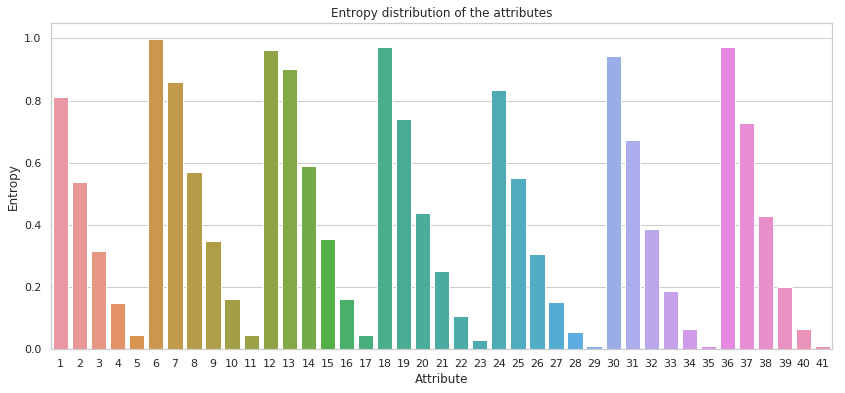

In [73]:
plt.figure(figsize=[14,6])
sns.set(style="whitegrid")
sns.barplot(x=list(attr_entropy.keys()), y=list(attr_entropy.values()))
plt.xlabel('Attribute')
plt.ylabel('Entropy')
plt.title('Entropy distribution of the attributes')
plt.show()

## Filter attributes by threshold
### lb =0.05
### ub =0.95


In [74]:

lb = 0.02
ub = 0.98
attr_list = []
for k,v in attr_entropy.items():
    if v >= lb and v<= ub:
        attr_list.append(k)
        

In [75]:
len(attr_list)

37

In [76]:
valid_attr = ['id']
valid_attr.extend(attr_list)
valid_attr.append('tag')
data_df = data_df[valid_attr]

## Explore Arity of the domains

In [77]:
def get_domain_arity(df,attr_list):
    domain_arity = {a: len(set(df[a])) for a in attr_list}
    return domain_arity

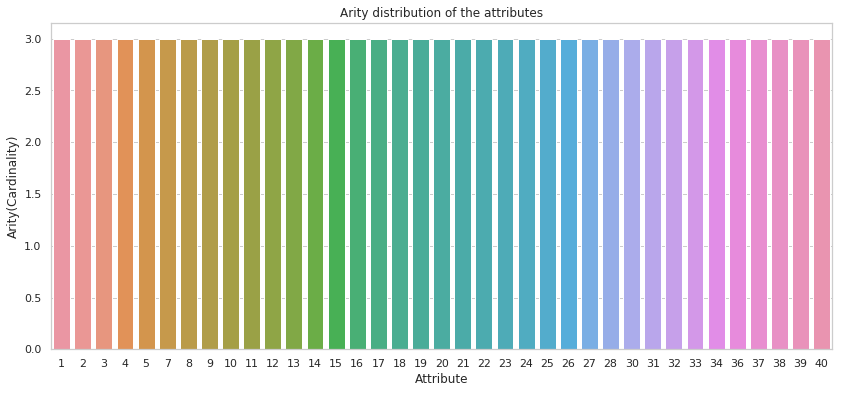

In [85]:

domain_arity = get_domain_arity(data_df,attr_list)
plt.figure(figsize=[14,6])
sns.set(style="whitegrid")
sns.barplot(x=list(domain_arity.keys()), y=list(domain_arity.values()))
plt.xlabel('Attribute')
plt.ylabel('Arity(Cardinality)')
plt.title('Arity distribution of the attributes')
plt.show()  

In [52]:
def replace_attr_with_id(row, attr, val2id_dict):
    val = row[attr]
    if val not in val2id_dict.keys():
        print(attr,val)
        return None
    else:
        return val2id_dict[val]


def convert_to_ids(df, cols , save_dir):
    domain_dims_dict = {}

    for col in cols:

        vals = list(set(df[col]))
        id2val_dict = {e[0]: e[1] for e in enumerate(vals, 0)}

        file_name = str(col) +'_id2val.pkl'
        with open( os.path.join(save_dir,file_name), 'wb') as f:
            pickle.dump(id2val_dict, f, pickle.HIGHEST_PROTOCOL)

        val2id_dict = {v: k for k, v in id2val_dict.items()}
        # replace
        df[col] = df.apply(
            replace_attr_with_id,
            axis=1,
            args=(
                col,
                val2id_dict,
            )
        )
        domain_dims_dict[col] = len(id2val_dict)

    domain_dims = []
    domain_dims_res = {}

    for col in list(df.columns):
        if col in domain_dims_dict.keys():
            print(col)
            domain_dims_res[col] = domain_dims_dict[col]
            domain_dims.append(domain_dims_dict[col])

    domain_dims =  np.array(domain_dims)
    file = 'domain_dims.pkl'
    f_path = os.path.join(save_dir, file)

    with open(f_path,'wb') as fh:
        pickle.dump(
            domain_dims_res,
            fh,
            pickle.HIGHEST_PROTOCOL
        )
    return df

In [79]:
# Save the data ina numpy array
_tmp = data_df[data_df['tag'] == normal_class]
_normal = list(_tmp['id'])


_tmp = data_df[(data_df['tag'] == anomaly_class_1) | (data_df['tag'] == anomaly_class_2)]
_anomaly =  list(_tmp['id'])


all_ids = list(data_df['id'])
record_id_dict ={
    'all':all_ids,
    'normal':_normal,
    'anomaly':_anomaly
}

In [ ]:
save_dir = '../Data/data_1'

data_df_1 = pd.DataFrame(data_df,copy=True)
try:
    del data_df_1['id']
    del data_df_1['tag']
except:
    pass

# convert all values to int
for c in list(data_df_1.columns):
    data_df_1[c] = data_df_1[c].astype(str)  
cols = list(data_df_1.columns)
data_df_1 = convert_to_ids(data_df_1, cols , save_dir)
data_x = data_df_1.values
    

In [84]:
OP_PATH = '../Data/data_1'
data_x_file = 'data_1_x.pkl'
record_file = 'data_1_idList.pkl'

f_path_1 = os.path.join(OP_PATH,data_x_file)
f_path_2 = os.path.join(OP_PATH,record_file)

with open(f_path_1,'wb') as fh :
    pickle.dump(data_x, fh,pickle.HIGHEST_PROTOCOL)
    
with open(f_path_2,'wb') as fh :
    pickle.dump(record_id_dict, fh,pickle.HIGHEST_PROTOCOL)